# Goals of the notebook

*Disclaimer: This is work in progress and notebook files are in the process of being re-organized.*

The goal of this notebook is to provide an overview of the automation that has been put in place to run experiments and analyze the results, which allows fast iterations and reproducibility.
Observations and next steps are documented in file TODO.md in same folder.

Recall that our filter is supposed to detect Out-Of-Domain (OOD) sentences from In-Domain (ID) sentences in a conversation between a support agent and a customer.
The goal is to build a system that can be used by any call-center-like that just provides its Knowledge-Base to train the system.

Here the knowledgebase/domain (ID) is an FAQ scrapped from the internet. The FAQs tested are:
- the Europcar website (from https://faq.europcar.com/ and subpages). The domain is a "Car rental" company.
- The NIH website (from https://seed.nih.gov/faqs). The domain is "Innovation in Health".
- the FDA website (from https://www.fda.gov/ specifically the Covid-19 faq). The domain is "Covid".
- the Olympics website (from https://olympics.com/ioc/faq and subpages). The domain is "Olympics".
- the WWF website (from https://www.wwf.org.uk/faqs and subpages). The domain is "World Wildlife Fund".
- the Fedora FAQ (from https://fedoraproject.org/wiki/FAQ#Getting_Started). The domain is the "Fedora Linux Project".

Each model built is specific (trained-on) a single FAQ.

## Code put in place

The folders of the project relevant to this notebook are:
- `train`: contains the code to run some training from a "model-card" file. A model card is a yaml file that looks like bellow. Each run of an experiment creates its own subfolder in `train/outputs` that contains the model card used, the training logs, the model weights, the validation results, etc. (Uses [hydra](https://hydra.cc/) behind the scenes)
```yaml
name: GaussianEmbeddingsAnomalyDetector
run_params:
  embedder_name: all-MiniLM-L6-v2
  robust_covariance: true
datasets:
  train_id_datasets:
  - olympics
  train_ood_datasets: []
  validation_id_dataset: validation_olympics_id
  validation_ood_dataset: validation_olympics_ood
```


- `dataload`: abstraction of the datafiles for easier loading when files are moved around (in code files are designated by simple name like "fda" or "olympics" regarless of folder location)
- `analysis`: contains some code to track experiments (similar to MLFlow - but didn't know about this at the time) and to analyze the results
- `gen`: generate validation and test datasets by randomly selection utterances from the chatterbox dataset and from the faqs
- `resources/scraping`: contains the scraped FAQs -each being a different domain. The scraping code for each can be found in `scraping/scraping.py`


## Some experiments run

They vary mainly on the following things:
- the domain used for training. Each corresponding to a different FAQ (e.g. olympics, fda, etc.)
- the embeddings model used for training (e.g. all-MiniLM-L6-v2, all-mpnet-base-v2, etc.)

In [1]:
from analysis.experiments import Experiments
from pathlib import Path

experiments = Experiments(Path("../train/outputs"))

In [2]:
for exp in sorted(experiments.list()):
    if exp.success:
        print(exp)

===== 2023-01-28 08-50-31 =====
Status: SUCCESS
F1-Score: 0.981
Info:
	PipelineInfoCard(name='GaussianEmbeddingsAnomalyDetector',
	                 run_params={'embedder_name': 'all-mpnet-base-v2',
	                             'robust_covariance': True},
	                 datasets=FilterTrainFiles(validation_id='validation_id',
	                                           validation_ood='validation_ood',
	                                           train_id=['europcar'],
	                                           train_ood=[]))

===== 2023-01-28 09-41-34 =====
Status: SUCCESS
F1-Score: 0.98
Info:
	PipelineInfoCard(name='GaussianEmbeddingsAnomalyDetector',
	                 run_params={'embedder_name': 'all-MiniLM-L6-v2',
	                             'robust_covariance': True},
	                 datasets=FilterTrainFiles(validation_id='validation_id',
	                                           validation_ood='validation_ood',
	                                           train_id=['euro

## Some results

For result analysis and dataset analysis (yes some additional pre-processing will be required for better results), we will use mainly 3 tools

1. Histograms on the validation and test sets: Those histogram plot the maha distance of the embeddings for each sentence of the set (a mix of ID and OOD sentences). Is also displays the computed cutoff. For details please refer to the notebook `performance_baseline.ipynb` in same folder

[nltk_data] Downloading package wordnet to /Users/jlinho/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jlinho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


===== 2023-02-13 00-03-32 =====
Status: SUCCESS
F1-Score: 0.987
Info:
	PipelineInfoCard(name='GaussianEmbeddingsAnomalyDetector',
	                 run_params={'embedder_name': 'all-MiniLM-L6-v2',
	                             'robust_covariance': True},
	                 datasets=FilterTrainFiles(train_id=['wwf'],
	                                           train_ood=[],
	                                           validation_id='validation_wwf_id',
	                                           validation_ood='validation_wwf_ood'))



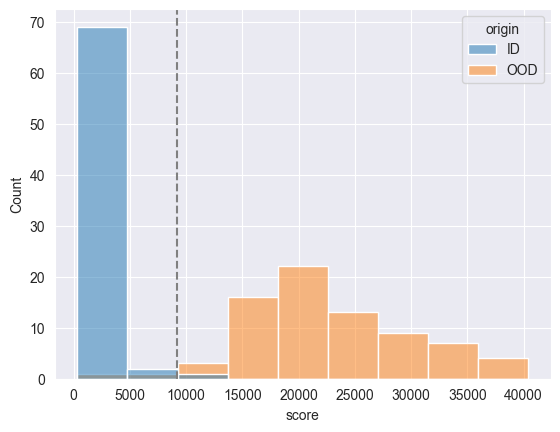

In [3]:
from analysis.histograms import plot_cutoff_histogram

experiment_name = "2023-02-13 00-03-32"
experiment_folder = experiments.find_folder(experiment_name)
print(experiments.find(experiment_name))
plot_cutoff_histogram(experiment_folder)

2. Embedding visualization: This is a 2D or 3D projection of the embeddings tensorboard projector. From each experiment we can produce embeddings of every sentence of the FAQ. The goal is to identify sentences that are part of the FAQ/Domain but not so domain specific  like: "Click here for more information", "For futher info click here", etc. Let's call those sentences **Stop Sentences** . For more information please look at the notebook `embeddings_eda.ipynb` in same folder. Those vizualitions are usefull to identify more pre-processing steps to make each domain more "specific", "domain-dense". Those vizualizations look like this (here on dataset `europcar`): ![embeddings1](useless_sentences.png)

3. Listing of misclassified sentences